# Explore and Finalize Feature Data

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from prelim_data_functions import educval_to_category, country_to_income_level, combine_gains_losses


# Data Pre-Processing

In [79]:
""" Applies a number of user defined functions to dataset.
    Before exporting dataset to CSV for analysis.
    To turn off a user defined function, simply comment it out.
    All user defined functions documented in prelim_data_functions.py"""

#Load flattened data into dataframe. Replace ?'s with null values.
flattened_df = pd.read_csv('./datasets/flattened_data.csv')
flattened_df = flattened_df.replace('?', np.nan)

#If know marital status and sex for a record, 'relationship' column is redundant. Drop.
flattened_df = flattened_df.drop(columns='relationship')
prelim_prep_df = flattened_df

# Groups education variable into more meaningful categories to aid interpretability.
# See educval_to_category in prelim_data_functions.py for documentation.
prelim_prep_df = educval_to_category(prelim_prep_df)

# Should not be able to have any records with positive capital gains and losses.
# If it is the case that gains and losses are opposite sides of same variable, combine into one variable,
# equal to capital gains - capital losses. See combine_gains_losses in prelim_data_functions.py for documentation.
prelim_prep_df = combine_gains_losses(prelim_prep_df)

# Categorize countries of origin by income level to further model extensibility.
# See country_to_income_level in prelim_data_functions.py for documentation.
prelim_prep_df = country_to_income_level(prelim_prep_df)

# Export to CSV
export_file_name = "./prelim_prepped_data.csv"
prelim_prep_df.to_csv(export_file_name, index=False)
print(f"Success! {len(prelim_prep_df)} rows exported to {export_file_name}.")


Replaced record value for education level with more informative category value for 48842 rows.
Replaced capital gains with capital gains - capital losses for 48842 rows.
Replaced country of origin with income category of country of origin for 48842 rows.
Success! 48842 rows exported to ./prelim_prepped_data.csv.


In [2]:
# Load data that has gone through preliminary preparation 
# See prelim_data_processing.py for full documentation of processing pipeline
prelim_df = pd.read_csv('./prelim_prepped_data.csv')

# label categorical and numerical columns
categorical_columns = ['educ_level', 'marital_status', 'occupation_name', 'race', 'sex', 'workclass', 'origin_c_income']
numerical_columns =['age', 'capital_gain', 'hours_week']


### Generate Summary Statistics

In [3]:
#Get summary stats for categorical columns
prelim_df.describe(include=np.object)

,educ_level,marital_status,occupation_name,race,sex,workclass,origin_c_income
count,48842,48842,46033,48842,48842,46043,47870
unique,10,7,14,5,2,8,5
top,hs_grad,Married-civ-spouse,Prof-specialty,White,Male,Private,US
freq,15784,22379,6172,41762,32650,33906,43832


NOTE: Census data is disproportionately white: 85.54384814070764%
and disproportionately male: 66.86687712680907% 


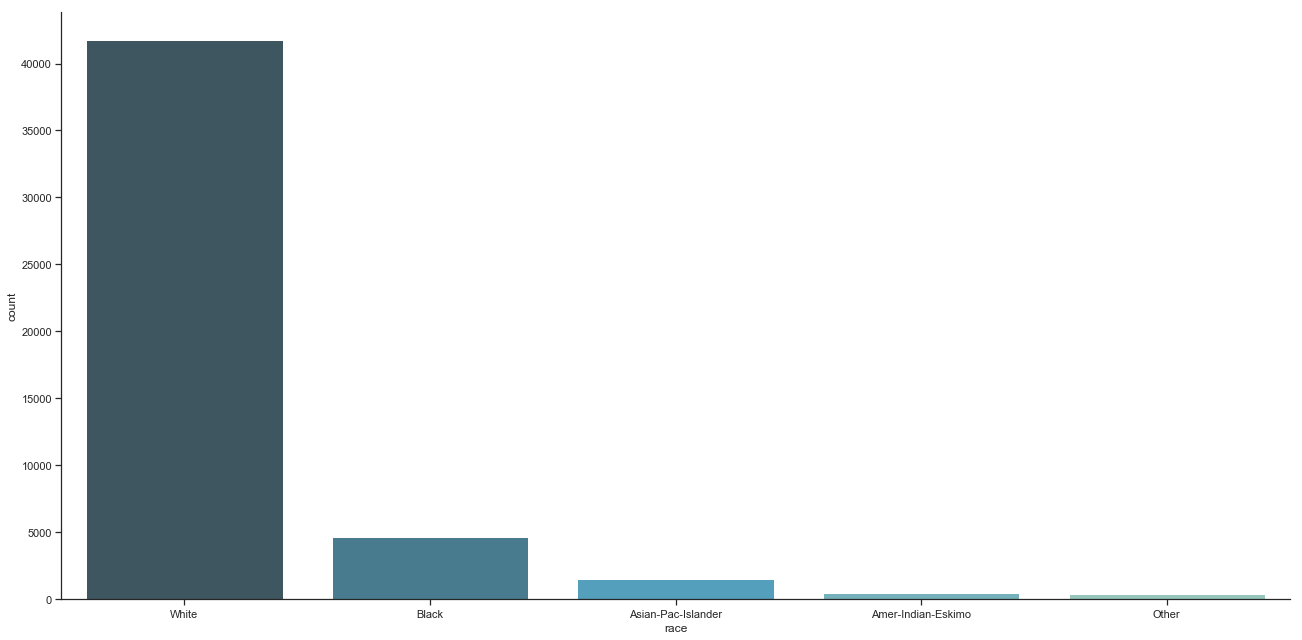

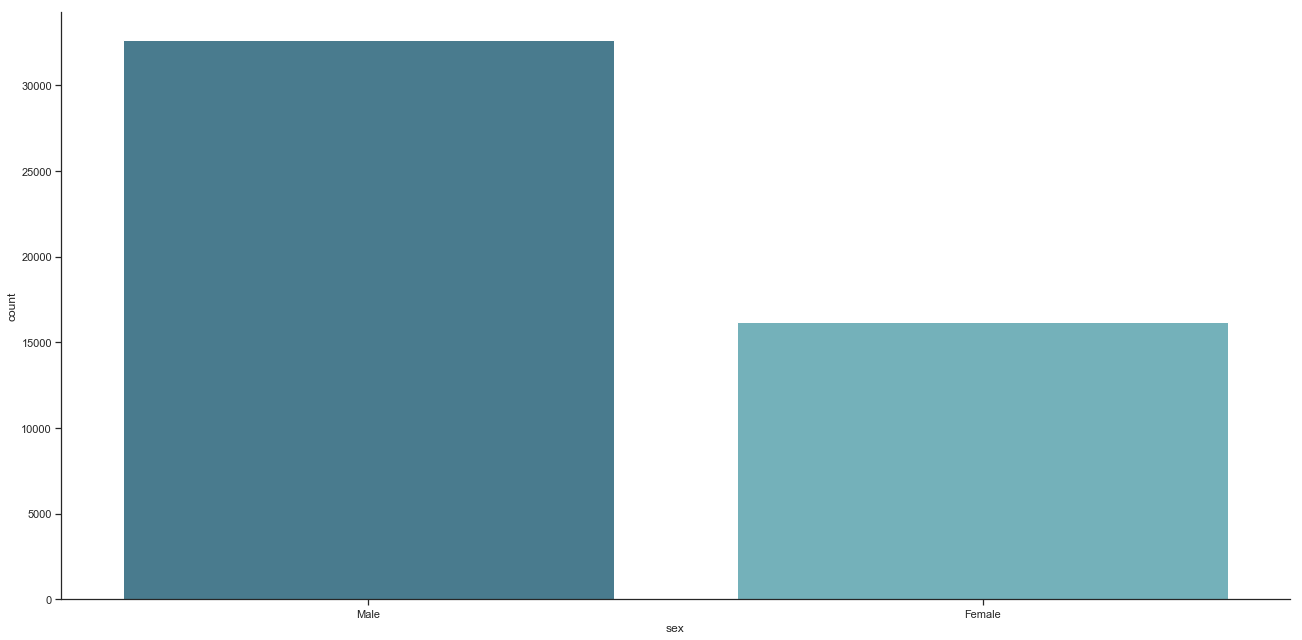

In [64]:
print(f"NOTE: Census data is disproportionately white: {(len(prelim_df[prelim_df['race'] == 'White'])/len(prelim_df))*100}%") 
print(f"and disproportionately male: {(len(prelim_df[prelim_df['sex'] == 'Male'])/len(prelim_df))*100}% ")      

sns.catplot(x='race', kind="count", palette="GnBu_d", data=prelim_df, height=len(set(feature)), aspect=len(set(feature))/(len(set(feature)))/0.5);  
sns.catplot(x='sex', kind="count", palette="GnBu_d", data=prelim_df, height=len(set(feature)), aspect=len(set(feature))/(len(set(feature)))/0.5);  


23.9412078225575% of respondents make > 50k


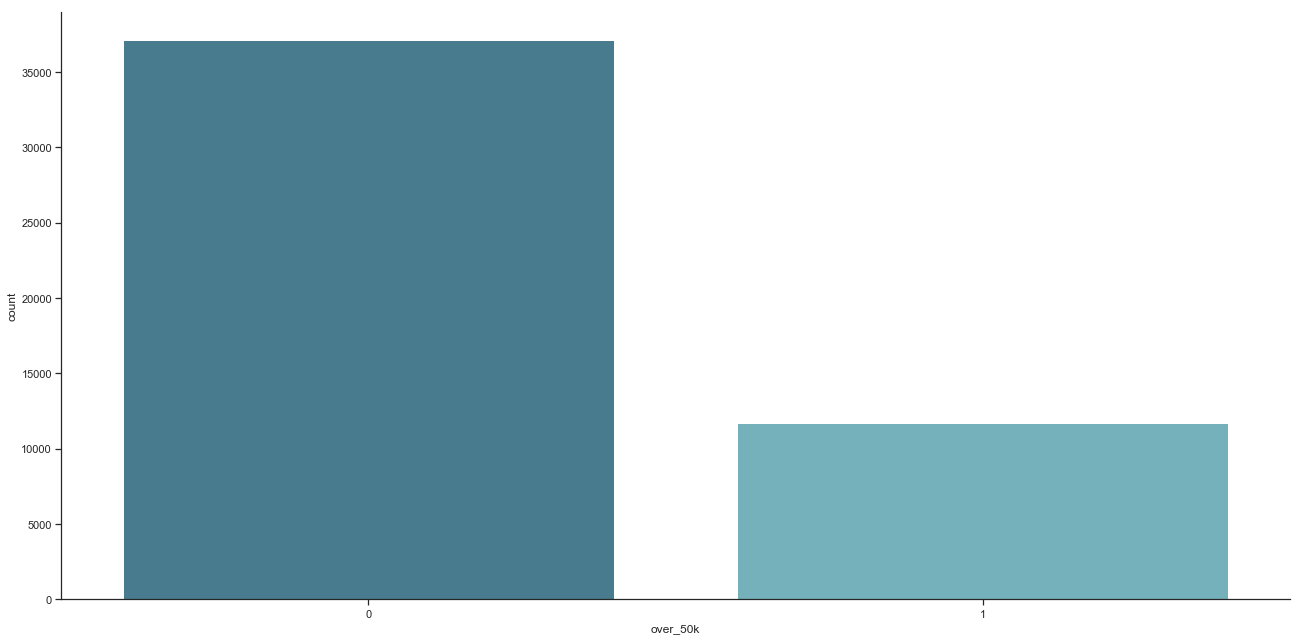

In [59]:
# Print frequency of outcome variable = 1 and outcome variable = 0
print(f"{(len(prelim_df[prelim_df['over_50k'] == 1])/len(prelim_df))*100}% of respondents make > 50k")
sns.catplot(x='over_50k', kind="count", palette="GnBu_d", data=prelim_df, height=len(set(feature)), aspect=len(set(feature))/(len(set(feature)))/0.5);

In [6]:
# Get summary stats for numeric columns
prelim_df.describe(include=np.number)

,age,capital_gain,hours_week,over_50k
count,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,991.565313,40.422382,0.239282
std,13.710510,7475.549906,12.391444,0.426649
min,17.000000,-4356.000000,1.000000,0.000000
25%,28.000000,0.000000,40.000000,0.000000
50%,37.000000,0.000000,40.000000,0.000000
75%,48.000000,0.000000,45.000000,0.000000
max,90.000000,99999.000000,99.000000,1.000000


In [67]:
# Strange concentration of $99,9999 values in capital_gains column. Check to see if other, nearby values present.
gain_counts = prelim_df['capital_gain'].value_counts().rename_axis('unique_values').reset_index(name='counts')
gain_counts.sort_values(by='unique_values')


,unique_values,counts
182,-4356,3
189,-3900,2
165,-3770,4
195,-3683,2
194,-3175,2
145,-3004,5
87,-2824,14
198,-2754,2
131,-2603,7
79,-2559,17


In [8]:
# 244 $999999 values and next closest value = $41,310 (freq=3). Appears 99999 may be placeholder for
# unknown, or all capital gains > 5 digits in length. Uncomment code below to mark as unknown; for now assuming
# 99999 is placeholder for gains > 5 digits in length.

#prelim_df['capital_gain'] = prelim_df['capital_gain'].replace({99999:np.nan})

### Analyze missing values

In [9]:
# 8 Percent of all rows have a null feature value.
percentage_null = ((prelim_df.drop(columns='over_50k').isnull().any(axis=1).value_counts()) / len(prelim_df)) *100
percentage_null

False    92.381557
True      7.618443
dtype: float64

In [10]:
# But no rows have a null outcome variable (over 50k)
percentage_outcomevar_null = ((prelim_df.isnull().over_50k.value_counts()) / len(prelim_df)) *100
percentage_outcomevar_null

False    100.0
Name: over_50k, dtype: float64

In [11]:
# Nearly 10% of records contain a null value, should impute values rather than drop all observations.
# See how many rows have multiple missing values. 
for number_missing in list(range(0,11)):
    percent_dropped = ((len(prelim_df) - len(prelim_df.dropna(thresh=11-number_missing, axis=0)))/len(prelim_df))*100
    print(f'Constraint: {number_missing} or more missing \t Percentage dropped: {percent_dropped}')


Constraint: 0 or more missing 	 Percentage dropped: 7.61844314319643
Constraint: 1 or more missing 	 Percentage dropped: 5.7307235575938735
Constraint: 2 or more missing 	 Percentage dropped: 0.12284509233856107
Constraint: 3 or more missing 	 Percentage dropped: 0.0
Constraint: 4 or more missing 	 Percentage dropped: 0.0
Constraint: 5 or more missing 	 Percentage dropped: 0.0
Constraint: 6 or more missing 	 Percentage dropped: 0.0
Constraint: 7 or more missing 	 Percentage dropped: 0.0
Constraint: 8 or more missing 	 Percentage dropped: 0.0
Constraint: 9 or more missing 	 Percentage dropped: 0.0
Constraint: 10 or more missing 	 Percentage dropped: 0.0


In [12]:
#If we drop only rows with > 2 values missing, only drop 0.12% of our dataset. Likely can afford this loss in power.
prelim_df = prelim_df.dropna(thresh=9, axis=0)

#For numerical values, fill in nulls with mean. For categorical, fill in with the mode.
prelim_df[numerical_columns] = prelim_df[numerical_columns].fillna(prelim_df.median().iloc[0])
prelim_df[categorical_columns] = prelim_df[categorical_columns].fillna(prelim_df.mode().iloc[0])

In [14]:
# Make categorical variables into dummies; Export final dataset for use in model classification
prepped_df = pd.get_dummies(prelim_df, prefix=categorical_columns, columns=categorical_columns, drop_first=True)
prepped_df.to_csv('./datasets/fully_prepped.csv')

### Analyze Numeric Features

In [76]:
# Create function to output mean of each variable, correlation with outcome variable, and box plot of each variable
def analyze_num_feature(num_feature):
    #plt.boxplot(prepped_df[num_feature])
    sns.boxplot(x=num_feature, palette="GnBu_d", data=prelim_df);
    plt.title(f"Box Plot of {num_feature.title()}")
    plt.show()

    feature_mean = prepped_df[num_feature].mean()
    feature_corr = prepped_df[num_feature].corr(prepped_df['over_50k'])
    print(f"Mean: {feature_mean}\nCorrelation w/ over_50k: {feature_corr}")



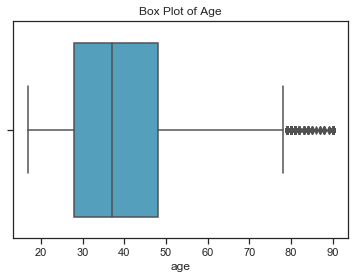

Mean: 38.64913287688082
Correlation w/ over_50k: 0.2304694899769631


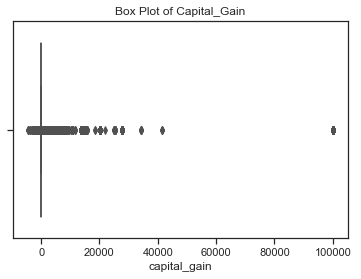

Mean: 990.5304415563118
Correlation w/ over_50k: 0.21427589815009362


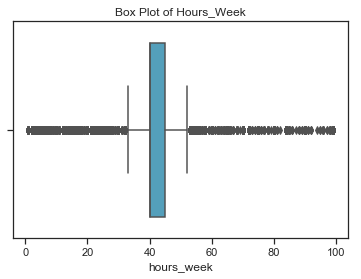

Mean: 40.43347956213358
Correlation w/ over_50k: 0.22762001931346132


In [77]:
for feature in numerical_columns:
    analyze_num_feature(feature)

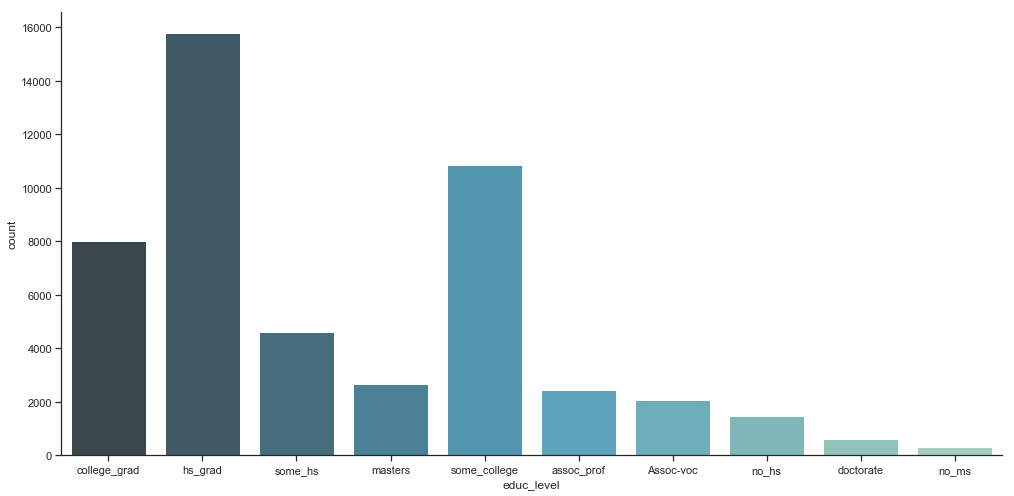

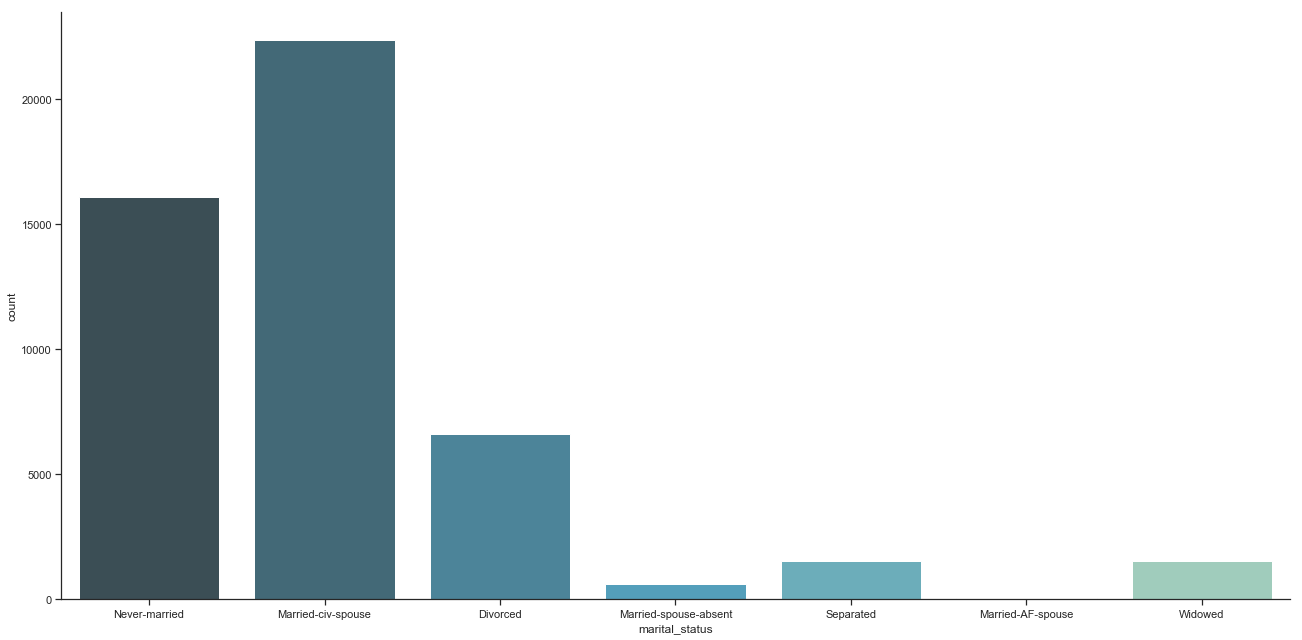

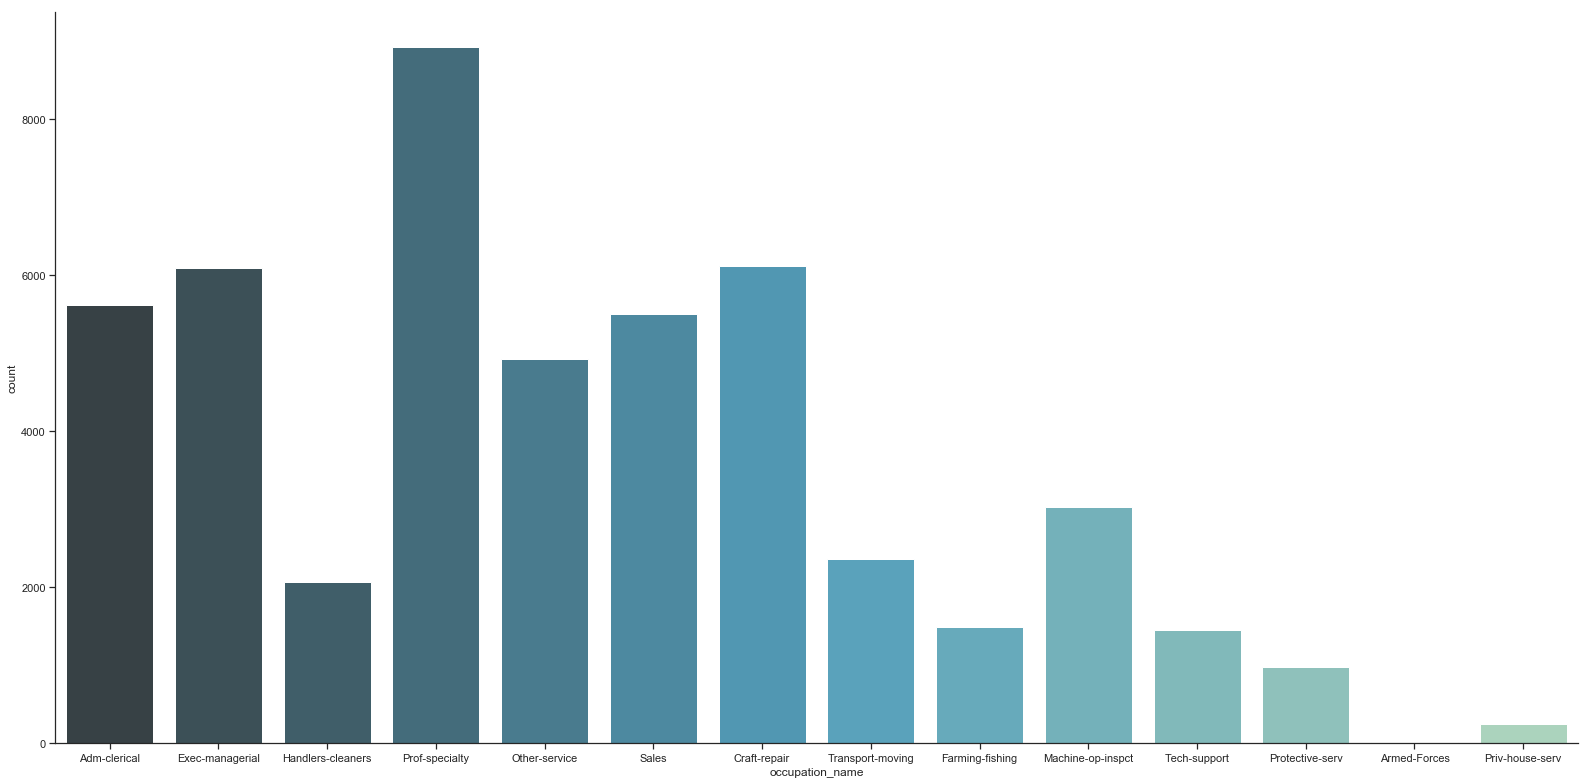

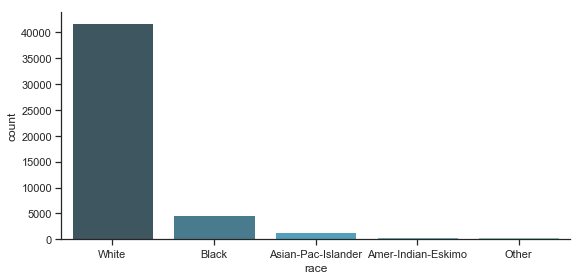

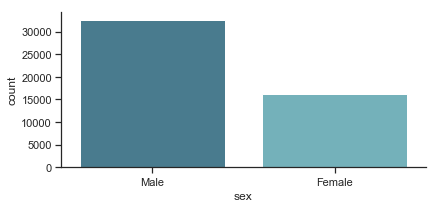

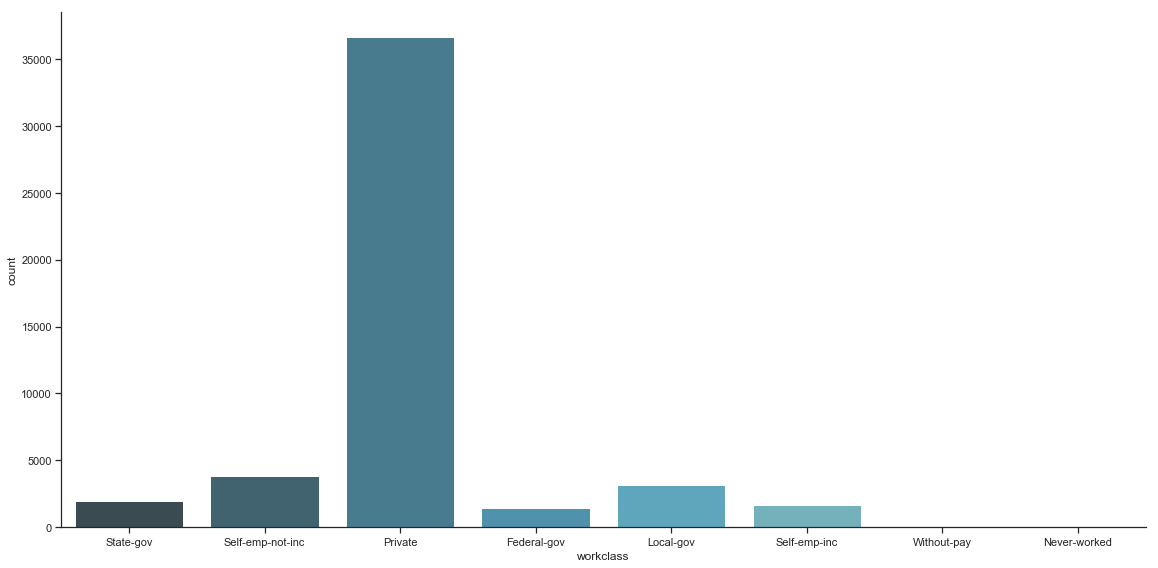

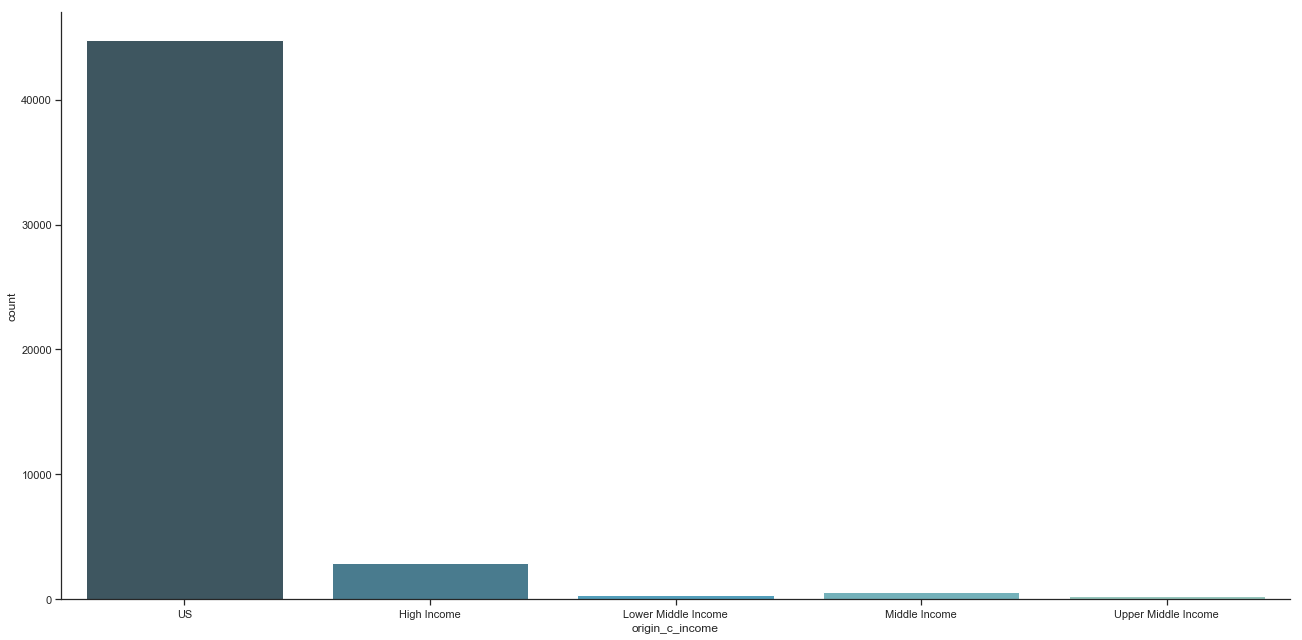

In [57]:
# Plot frequency charts for categorical values
for feature in categorical_columns:
    sns.catplot(x=feature, kind="count", palette="GnBu_d", data=prelim_df, height=len(set(feature)), aspect=len(set(feature))/(len(set(feature)))/0.5);